In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
# Import Libraries
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType, LongType
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
Pandas version: 2.3.3


In [2]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("AirbnbAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print("Spark session created")
print(f"Spark version: {spark.version}")
spark

Spark session created
Spark version: 4.0.1


In [3]:
# Configuration Parameters
class Config:
    # File paths
    LISTINGS_PATH = '../data/listings.csv'
    REVIEWS_PATH = '../data/reviews.csv'
    OUTPUT_DIR = '../data/'

    # Filtering thresholds
    MIN_USER_REVIEWS = 3  # Minimum reviews per user
    MIN_LISTING_REVIEWS = 5  # Minimum reviews per listing

    # Train/test split
    TRAIN_RATIO = 0.8
    RANDOM_SEED = 42


config = Config()
print("Configuration set")

Configuration set


In [4]:
# Load Raw Data
print("Loading data...")

listings_cols = [
    'id', 'name', 'description', 'neighbourhood_cleansed',
    'latitude', 'longitude', 'property_type', 'room_type',
    'accommodates', 'bedrooms', 'beds', 'price',
    'minimum_nights', 'number_of_reviews', 'review_scores_rating',
    'review_scores_location', 'review_scores_value',
    'host_is_superhost', 'instant_bookable', 'picture_url'
]

reviews_cols = ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

listings_raw = pd.read_csv(config.LISTINGS_PATH, usecols=listings_cols)
reviews_raw = pd.read_csv(config.REVIEWS_PATH, usecols=reviews_cols)

print(f"✓ Loaded {len(listings_raw):,} listings")
print(f"✓ Loaded {len(reviews_raw):,} reviews")
print(f"✓ Unique users: {reviews_raw['reviewer_id'].nunique():,}")
print(f"✓ Unique listings: {reviews_raw['listing_id'].nunique():,}")

Loading data...
✓ Loaded 36,111 listings
✓ Loaded 986,597 reviews
✓ Unique users: 869,544
✓ Unique listings: 24,923


C:\Users\Tal\AppData\Local\Temp\ipykernel_8336\2391015744.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  reviews_by_month = reviews_raw.set_index('date').resample('M').size()


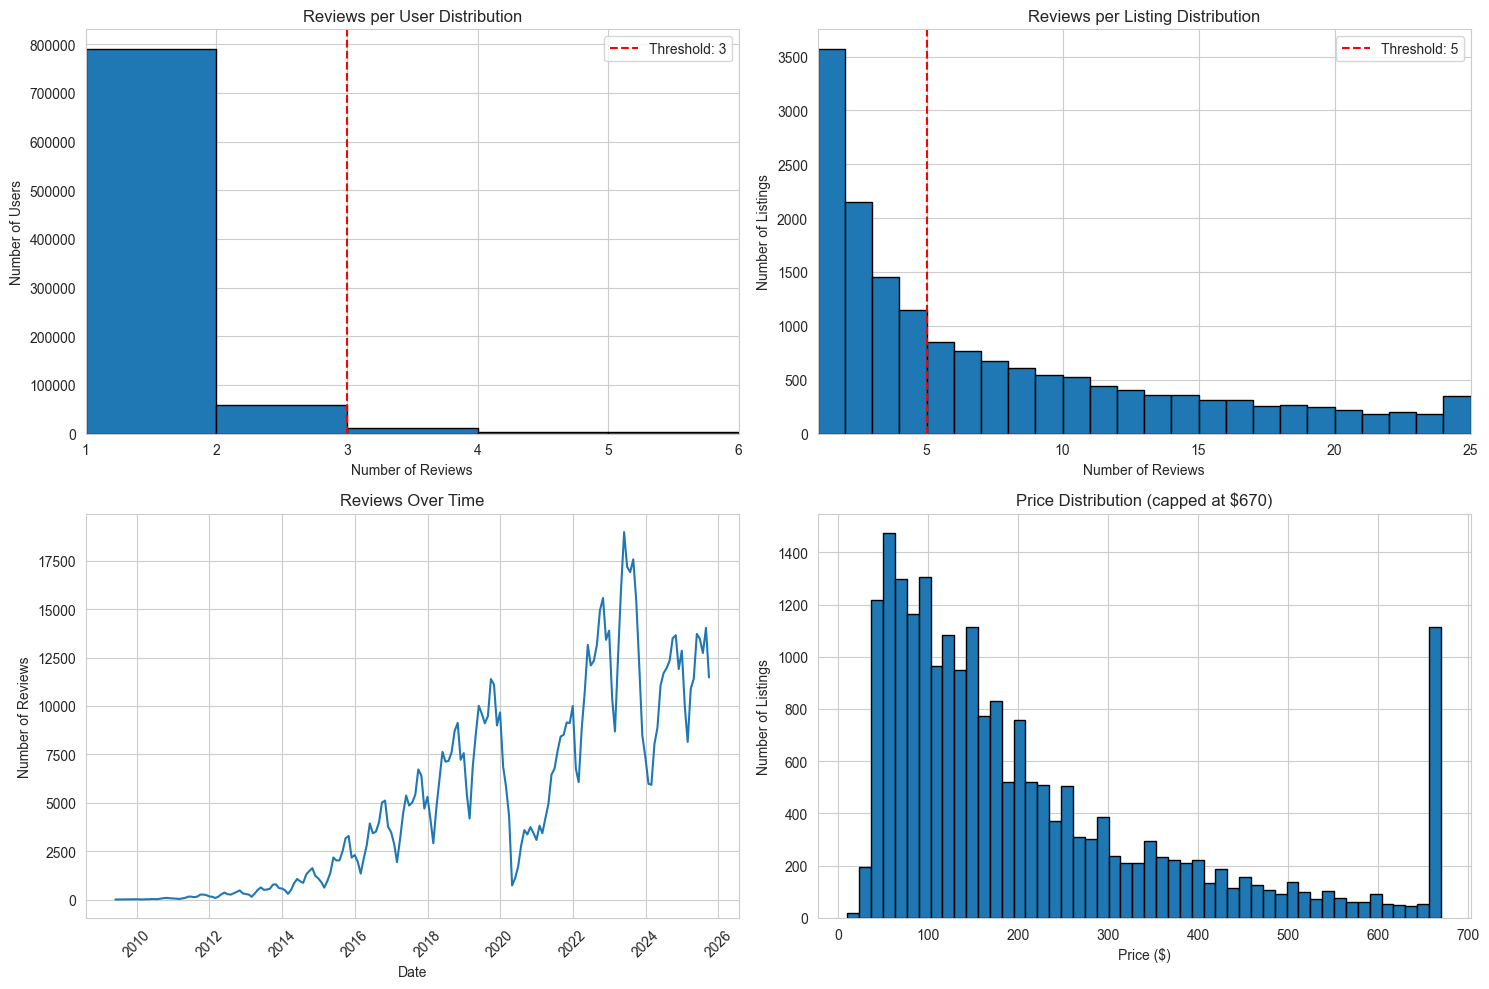

Users with ≥3 reviews: 19,713
Listings with ≥5 reviews: 16,594


In [5]:
# Visualize Distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Reviews per user
user_review_counts = reviews_raw['reviewer_id'].value_counts()
axes[0, 0].hist(user_review_counts, bins=range(1, 7), edgecolor='black')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_title('Reviews per User Distribution')
axes[0, 0].axvline(config.MIN_USER_REVIEWS, color='red', linestyle='--',
                   label=f'Threshold: {config.MIN_USER_REVIEWS}')
axes[0, 0].set_xlim(1, 6)
axes[0, 0].legend()

# Reviews per listing
listing_review_counts = reviews_raw['listing_id'].value_counts()
axes[0, 1].hist(listing_review_counts, bins=range(1, 26), edgecolor='black')
axes[0, 1].set_xlabel('Number of Reviews')
axes[0, 1].set_ylabel('Number of Listings')
axes[0, 1].set_title('Reviews per Listing Distribution')
axes[0, 1].axvline(config.MIN_LISTING_REVIEWS, color='red', linestyle='--',
                   label=f'Threshold: {config.MIN_LISTING_REVIEWS}')
axes[0, 1].set_xlim(1, 25)
axes[0, 1].legend()

# Reviews over time
reviews_raw['date'] = pd.to_datetime(reviews_raw['date'])
reviews_by_month = reviews_raw.set_index('date').resample('M').size()
axes[1, 0].plot(reviews_by_month[:-1])
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].set_title('Reviews Over Time')
axes[1, 0].tick_params(axis='x', rotation=45)

# Price distribution
axes[1, 1].hist(listings_raw['price'].str.replace('$', '').str.replace(',', '').astype(float).dropna().clip(0, 670),
                bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Price ($)')
axes[1, 1].set_ylabel('Number of Listings')
axes[1, 1].set_title('Price Distribution (capped at $670)')

plt.tight_layout()
plt.show()

print(f"Users with ≥{config.MIN_USER_REVIEWS} reviews: {(user_review_counts >= config.MIN_USER_REVIEWS).sum():,}")
print(
    f"Listings with ≥{config.MIN_LISTING_REVIEWS} reviews: {(listing_review_counts >= config.MIN_LISTING_REVIEWS).sum():,}")

In [6]:
# Clean Listings Data
listings_clean = listings_raw.copy()

# 1. Clean price
listings_clean['price'] = listings_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)

# 2. Handle missing values

# listings_clean['review_scores_rating'].fillna(
#     listings_clean['review_scores_rating'].median(),
#     inplace=True
# )

listings_clean['bedrooms'].fillna(0, inplace=True)
listings_clean['beds'].fillna(0, inplace=True)

# 3. Convert boolean columns
listings_clean['host_is_superhost'] = listings_clean['host_is_superhost'].map({'t': True, 'f': False}).fillna(False)
listings_clean['instant_bookable'] = listings_clean['instant_bookable'].map({'t': True, 'f': False}).fillna(False)

# 4. Rename id column for clarity
listings_clean.rename(columns={'id': 'listing_id'}, inplace=True)

print("✓ Listings data cleaned")
print(f"Price range: ${listings_clean['price'].min():.2f} - ${listings_clean['price'].max():.2f}")
print(f"Median price: ${listings_clean['price'].median():.2f}")

✓ Listings data cleaned
Price range: $10.00 - $50104.00
Median price: $154.00


C:\Users\Tal\AppData\Local\Temp\ipykernel_8336\3317630980.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_clean['bedrooms'].fillna(0, inplace=True)
C:\Users\Tal\AppData\Local\Temp\ipykernel_8336\3317630980.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [7]:
# Cell 9: Apply Filtering
print("Applying filters...")
print(f"Original: {len(reviews_raw):,} reviews")

# Count reviews per user and listing
user_counts = reviews_raw['reviewer_id'].value_counts()
listing_counts = reviews_raw['listing_id'].value_counts()

# Identify active users and popular listings
active_users = user_counts[user_counts >= config.MIN_USER_REVIEWS].index
popular_listings = listing_counts[listing_counts >= config.MIN_LISTING_REVIEWS].index

print(f"Active users (≥{config.MIN_USER_REVIEWS} reviews): {len(active_users):,}")
print(f"Popular listings (≥{config.MIN_LISTING_REVIEWS} reviews): {len(popular_listings):,}")

# Apply filters
reviews_filtered = reviews_raw[
    reviews_raw['reviewer_id'].isin(active_users) &
    reviews_raw['listing_id'].isin(popular_listings)
    ].copy()

print(f"Filtered: {len(reviews_filtered):,} reviews")
print(f"Reduction: {(1 - len(reviews_filtered) / len(reviews_raw)) * 100:.1f}%")

# Update listings to only include those with reviews
listings_filtered = listings_clean[
    listings_clean['listing_id'].isin(reviews_filtered['listing_id'])
].copy()

print(f"Listings after filtering: {len(listings_filtered):,}")

# Calculate sparsity
n_users = reviews_filtered['reviewer_id'].nunique()
n_listings = reviews_filtered['listing_id'].nunique()
n_interactions = len(reviews_filtered)
sparsity = 1 - (n_interactions / (n_users * n_listings))

print(f"\nDataset Statistics:")
print(f"  Users: {n_users:,}")
print(f"  Listings: {n_listings:,}")
print(f"  Interactions: {n_interactions:,}")
print(f"  Sparsity: {sparsity * 100:.2f}%")


Applying filters...
Original: 986,597 reviews
Active users (≥3 reviews): 19,713
Popular listings (≥5 reviews): 16,594
Filtered: 76,174 reviews
Reduction: 92.3%
Listings after filtering: 12,004

Dataset Statistics:
  Users: 19,696
  Listings: 12,004
  Interactions: 76,174
  Sparsity: 99.97%



Filtered Rating distribution:
count    76174.000000
mean         3.000000
std          1.414232
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64


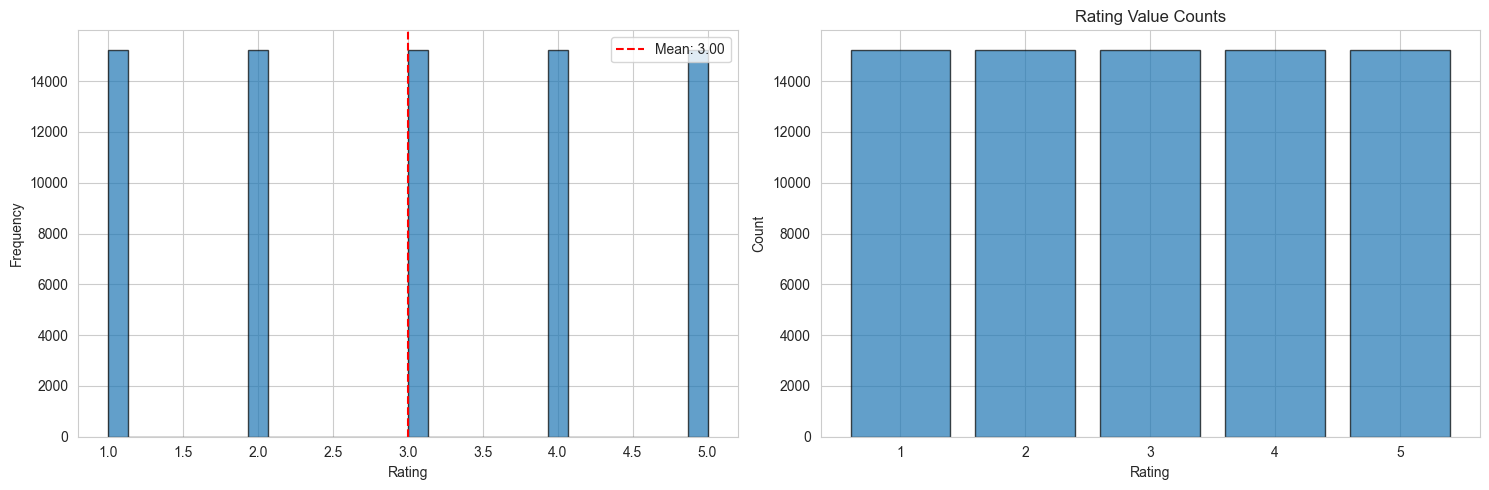

In [8]:
# Construct Ratings

def construct_filtered_quantile_ratings(reviews_df):
    """
    Quantile-based: Guarantees uniform distribution on filtered data
    20% each rating tier (1, 2, 3, 4, 5)
    """
    df = reviews_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['review_length'] = df['comments'].fillna('').astype(str).str.len()

    # Calculate features on FILTERED data
    max_date = df['date'].max()
    df['days_ago'] = (max_date - df['date']).dt.days

    # Count interactions (multiple reviews of same listing)
    interaction_counts = df.groupby(['reviewer_id', 'listing_id']).size().reset_index(name='interaction_count')
    df = df.merge(interaction_counts, on=['reviewer_id', 'listing_id'], how='left')

    # Composite score
    df['recency_score'] = np.exp(-df['days_ago'] / 730)  # 2-year decay
    df['length_score'] = np.log1p(df['review_length'])
    df['frequency_score'] = df['interaction_count']

    df['composite_score'] = (
            df['recency_score'] * 0.4 +
            df['length_score'] / df['length_score'].quantile(0.95) * 0.3 +
            df['frequency_score'] / df['frequency_score'].quantile(0.95) * 0.3
    )

    # Use qcut to create equal-sized bins (guarantees distribution)
    df['rating'] = pd.qcut(
        df['composite_score'],
        q=5,
        labels=[1.0, 2.0, 3.0, 4.0, 5.0],
        duplicates='drop'
    ).astype(float)

    return df


def construct_filtered_hybrid_ratings(reviews_df):
    """
    Balanced approach: Uses percentiles within filtered data
    Good variance without extreme skew
    """
    df = reviews_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['review_length'] = df['comments'].fillna('').astype(str).str.len()

    # Calculate features
    max_date = df['date'].max()
    df['days_ago'] = (max_date - df['date']).dt.days

    interaction_counts = df.groupby(['reviewer_id', 'listing_id']).size().reset_index(name='interaction_count')
    df = df.merge(interaction_counts, on=['reviewer_id', 'listing_id'], how='left')

    # Score each dimension separately using percentile ranks
    df['recency_percentile'] = df['days_ago'].rank(method='average', pct=True, ascending=False)
    df['length_percentile'] = df['review_length'].rank(method='average', pct=True)
    df['frequency_percentile'] = df['interaction_count'].rank(method='average', pct=True)

    # Weighted average of percentiles
    df['composite_percentile'] = (
            df['recency_percentile'] * 0.4 +
            df['length_percentile'] * 0.3 +
            df['frequency_percentile'] * 0.3
    )

    # Map percentile [0, 1] to rating [1, 5]
    df['rating'] = 1.0 + df['composite_percentile'] * 4.0
    df['rating'] = df['rating'].round(1)

    return df


def construct_user_relative_ratings(reviews_df):
    """
    Rate relative to each user's behavior
    Users who review more/longer give lower ratings to marginal listings
    Creates natural variance
    """
    df = reviews_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['review_length'] = df['comments'].fillna('').astype(str).str.len()

    # Calculate user statistics
    user_stats = df.groupby('reviewer_id').agg({
        'review_length': ['mean', 'std'],
        'listing_id': 'count'
    }).reset_index()
    user_stats.columns = ['reviewer_id', 'user_avg_length', 'user_std_length', 'user_review_count']

    df = df.merge(user_stats, on='reviewer_id', how='left')

    # Calculate z-score relative to user's behavior
    df['length_z'] = (df['review_length'] - df['user_avg_length']) / (df['user_std_length'] + 1)

    # Recency relative to user's review timeline
    user_dates = df.groupby('reviewer_id')['date'].agg(['min', 'max']).reset_index()
    user_dates.columns = ['reviewer_id', 'user_first_review', 'user_last_review']
    df = df.merge(user_dates, on='reviewer_id', how='left')

    df['user_review_span'] = (df['user_last_review'] - df['user_first_review']).dt.days + 1
    df['review_position'] = (df['date'] - df['user_first_review']).dt.days / df['user_review_span']

    # Interaction frequency
    interaction_counts = df.groupby(['reviewer_id', 'listing_id']).size().reset_index(name='interaction_count')
    df = df.merge(interaction_counts, on=['reviewer_id', 'listing_id'], how='left')

    # Combine signals (user-relative)
    df['rating'] = 3.0  # Base
    df['rating'] += df['length_z'].clip(-1, 1)  # +/- 1 based on length
    df['rating'] += df['review_position'] * 0.5  # Up to +0.5 for recent
    df['rating'] += (df['interaction_count'] - 1) * 0.3  # +0.3 per repeat

    df['rating'] = df['rating'].clip(1.0, 5.0).round(1)

    return df


def construct_aggressive_spread_ratings(reviews_df):
    """
    MAXIMUM VARIANCE: Aggressively spread ratings using multiple signals
    Target: mean=3.0, std=1.2
    """
    df = reviews_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['review_length'] = df['comments'].fillna('').astype(str).str.len()

    # Feature engineering
    max_date = df['date'].max()
    df['days_ago'] = (max_date - df['date']).dt.days

    # Interaction counts
    interaction_counts = df.groupby(['reviewer_id', 'listing_id']).size().reset_index(name='interaction_count')
    df = df.merge(interaction_counts, on=['reviewer_id', 'listing_id'], how='left')

    # User activity level (active users are pickier)
    user_activity = df.groupby('reviewer_id').size().reset_index(name='user_activity')
    df = df.merge(user_activity, on='reviewer_id', how='left')

    # Listing popularity (popular listings get higher ratings)
    listing_popularity = df.groupby('listing_id').size().reset_index(name='listing_popularity')
    df = df.merge(listing_popularity, on='listing_id', how='left')

    # Create multiple features
    df['recency_norm'] = (df['days_ago'].max() - df['days_ago']) / df['days_ago'].max()
    df['length_norm'] = df['review_length'] / df['review_length'].quantile(0.95)
    df['frequency_norm'] = (df['interaction_count'] - 1) / 2  # 0, 0.5, 1+
    df['popularity_norm'] = np.log1p(df['listing_popularity']) / np.log1p(df['listing_popularity'].max())
    df['pickiness_factor'] = 1 / np.log1p(df['user_activity'])  # Active users pickier

    # Weighted combination with aggressive scaling
    df['raw_score'] = (
                              df['recency_norm'] * 1.5 +
                              df['length_norm'].clip(0, 1) * 1.0 +
                              df['frequency_norm'].clip(0, 1) * 1.0 +
                              df['popularity_norm'] * 0.5
                      ) * df['pickiness_factor']

    # Normalize to mean=3, std=1.2 using z-score
    mean_score = df['raw_score'].mean()
    std_score = df['raw_score'].std()
    df['z_score'] = (df['raw_score'] - mean_score) / std_score

    # Map to 1-5 with target std=1.2
    df['rating'] = 3.0 + df['z_score'] * 1.2
    df['rating'] = df['rating'].clip(1.0, 5.0).round(1)

    return df


reviews_with_ratings = construct_filtered_quantile_ratings(reviews_filtered)

print(f"\nFiltered Rating distribution:")
print(reviews_with_ratings['rating'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(reviews_with_ratings['rating'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].axvline(reviews_with_ratings['rating'].mean(), color='red', linestyle='--',
                label=f'Mean: {reviews_with_ratings["rating"].mean():.2f}')
axes[0].legend()

# Value counts
rating_counts = reviews_with_ratings['rating'].value_counts().sort_index()
axes[1].bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].set_title('Rating Value Counts')

plt.tight_layout()
plt.show()

In [9]:
# Create Final Interactions DataFrame
interactions = reviews_with_ratings[[
    'reviewer_id',
    'listing_id',
    'rating',
    'date'
]].copy()

# Remove duplicates (keep most recent review if user reviewed same listing multiple times)
interactions = interactions.sort_values('date').drop_duplicates(
    subset=['reviewer_id', 'listing_id'],
    keep='last'
)

print(f"✓ Interactions DataFrame created")
print(f"Shape: {interactions.shape}")
print(f"\nSample:")
print(interactions.head())

✓ Interactions DataFrame created
Shape: (63013, 4)

Sample:
    reviewer_id  listing_id  rating       date
2         22786        6848     3.0 2009-07-22
94        29070        7801     2.0 2009-08-26
3         85066       12192     1.0 2010-03-18
40       126900        7097     1.0 2010-09-12
4        231210        6848     1.0 2010-10-24


In [10]:
interactions

,reviewer_id,listing_id,rating,date
2,22786,6848,3.0,2009-07-22
94,29070,7801,2.0,2009-08-26
3,85066,12192,1.0,2010-03-18
40,126900,7097,1.0,2010-09-12
4,231210,6848,1.0,2010-10-24
...,...,...,...,...
17244,477828215,14485372,5.0,2025-10-01
502,95121510,67299,5.0,2025-10-01
7118,21765701,4265471,5.0,2025-10-01
52368,90173339,52288075,5.0,2025-10-01


In [11]:
# Train/Test Split

# Split by user (ensure each user appears in both train and test)
train_data, test_data = train_test_split(
    interactions,
    test_size=(1 - config.TRAIN_RATIO),
    random_state=config.RANDOM_SEED,
    stratify=None  # Random split
)

print(f"✓ Data split into train/test")
print(f"Training set: {len(train_data):,} interactions")
print(f"Test set: {len(test_data):,} interactions")
print(
    f"Split ratio: {len(train_data) / len(interactions) * 100:.1f}% / {len(test_data) / len(interactions) * 100:.1f}%")

# Verify users/listings overlap
train_users = set(train_data['reviewer_id'])
test_users = set(test_data['reviewer_id'])
train_listings = set(train_data['listing_id'])
test_listings = set(test_data['listing_id'])

print(f"\nUsers in both sets: {len(train_users & test_users):,}")
print(f"Listings in both sets: {len(train_listings & test_listings):,}")


✓ Data split into train/test
Training set: 50,410 interactions
Test set: 12,603 interactions
Split ratio: 80.0% / 20.0%

Users in both sets: 9,182
Listings in both sets: 5,345


In [12]:
# Convert to Spark DataFrames

# Convert interactions to Spark
train_spark = spark.createDataFrame(train_data)
test_spark = spark.createDataFrame(test_data)

# Convert listings to Spark
listings_spark = spark.createDataFrame(listings_filtered)

print("✓ Converted to Spark DataFrames")
print("\nTrain schema:")
train_spark.printSchema()
print(f"\nTrain count: {train_spark.count():,}")

✓ Converted to Spark DataFrames

Train schema:
root
 |-- reviewer_id: long (nullable = true)
 |-- listing_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- date: timestamp (nullable = true)


Train count: 50,410


In [13]:
# Create Integer IDs for ALS
# Spark ALS requires integer IDs
user_indexer = StringIndexer(inputCol="reviewer_id", outputCol="user_id")
item_indexer = StringIndexer(inputCol="listing_id", outputCol="item_id")

# Fit indexers on training data
user_indexer_model = user_indexer.fit(train_spark)
item_indexer_model = item_indexer.fit(train_spark)

# Transform both train and test
train_indexed = user_indexer_model.transform(train_spark)
train_indexed = item_indexer_model.transform(train_indexed)

test_indexed = user_indexer_model.transform(test_spark)
test_indexed = item_indexer_model.transform(test_indexed)

# Cast to appropriate types
train_final = train_indexed.select(
    col("user_id").cast(LongType()),
    col("item_id").cast(LongType()),
    col("rating").cast(FloatType()),
    col("reviewer_id"),  # Keep original IDs for reference
    col("listing_id")
)

test_final = test_indexed.select(
    col("user_id").cast(LongType()),
    col("item_id").cast(LongType()),
    col("rating").cast(FloatType()),
    col("reviewer_id"),
    col("listing_id")
)

print("✓ User and item IDs indexed")
print("\nFinal train schema:")
train_final.printSchema()
print("\nSample:")
train_final.show(5)

✓ User and item IDs indexed

Final train schema:
root
 |-- user_id: long (nullable = true)
 |-- item_id: long (nullable = true)
 |-- rating: float (nullable = true)
 |-- reviewer_id: long (nullable = true)
 |-- listing_id: long (nullable = true)


Sample:
+-------+-------+------+-----------+------------------+
|user_id|item_id|rating|reviewer_id|        listing_id|
+-------+-------+------+-----------+------------------+
|  16015|     74|   2.0|   92143156|          17266124|
|    909|   1592|   1.0|   35477606|          35906886|
|   5995|     22|   5.0|  302574329|          26013177|
|   5654|  11074|   5.0|  272559982|929478160790239391|
|   8674|    592|   4.0|  676281091|          15381675|
+-------+-------+------+-----------+------------------+
only showing top 5 rows


In [14]:
# Save ID Mappings for Later Use
# Extract user ID mapping
user_mapping = train_indexed.select("reviewer_id", "user_id").distinct().toPandas()
user_mapping.to_csv(f'{config.OUTPUT_DIR}user_id_mapping.csv', index=False)

# Extract item ID mapping
item_mapping = train_indexed.select("listing_id", "item_id").distinct().toPandas()
item_mapping.to_csv(f'{config.OUTPUT_DIR}item_id_mapping.csv', index=False)

print(f"✓ Saved user mapping: {len(user_mapping):,} users")
print(f"✓ Saved item mapping: {len(item_mapping):,} items")

✓ Saved user mapping: 19,185 users
✓ Saved item mapping: 11,221 items


In [15]:
# Cell 15: Save All Processed Data

os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Save Spark DataFrames as Parquet (efficient columnar format)
train_final.write.mode('overwrite').parquet(f'{config.OUTPUT_DIR}train.parquet')

# JUST THIS IS BROKEN BUT EVERYTHING ELSE WORKS I CANT TAKE IT ANYMORE
test_final.write.mode('overwrite').parquet(f'{config.OUTPUT_DIR}test.parquet')

listings_spark.write.mode('overwrite').parquet(f'{config.OUTPUT_DIR}listings.parquet')

# Also save as CSV for easy inspection
train_final.limit(1000).toPandas().to_csv(f'{config.OUTPUT_DIR}train_sample.csv', index=False)
listings_filtered.to_csv(f'{config.OUTPUT_DIR}listings_metadata.csv', index=False)

print("✓ All data saved successfully")
print(f"\nFiles saved to: {config.OUTPUT_DIR}")
print("  - train.parquet")
print("  - test.parquet")
print("  - listings.parquet")
print("  - user_id_mapping.csv")
print("  - item_id_mapping.csv")
print("  - train_sample.csv")
print("  - listings_metadata.csv")

Py4JJavaError: An error occurred while calling o304.parquet.
: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] User defined function (`StringIndexerModel$$Lambda$5247/0x000001e8de234a58`: (string) => double) failed due to: org.apache.spark.SparkException: Unseen label: 585978214. To handle unseen labels, set Param handleInvalid to keep.. SQLSTATE: 39000
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:195)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1205)
	at org.apache.spark.sql.catalyst.expressions.Alias.eval(namedExpressions.scala:161)
	at org.apache.spark.sql.catalyst.expressions.InterpretedMutableProjection.apply(InterpretedMutableProjection.scala:89)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.$anonfun$applyOrElse$83(Optimizer.scala:2265)
	at scala.collection.immutable.ArraySeq.map(ArraySeq.scala:75)
	at scala.collection.immutable.ArraySeq.map(ArraySeq.scala:35)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.applyOrElse(Optimizer.scala:2265)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.applyOrElse(Optimizer.scala:2260)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.mapChildren(InsertIntoHadoopFsRelationCommand.scala:48)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformWithPruning(TreeNode.scala:436)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$.apply(Optimizer.scala:2260)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$.apply(Optimizer.scala:2258)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
	at scala.collection.immutable.ArraySeq.foldLeft(ArraySeq.scala:222)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyOptimizedPlan$2(QueryExecution.scala:202)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyOptimizedPlan$1(QueryExecution.scala:198)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.optimizedPlan(QueryExecution.scala:212)
	at org.apache.spark.sql.execution.QueryExecution.assertOptimized(QueryExecution.scala:214)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyExecutedPlan$1(QueryExecution.scala:234)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:248)
	at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:297)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:344)
	at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:312)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:149)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:295)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:124)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:237)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:155)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:154)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:169)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:164)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:446)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:164)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:126)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:192)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:622)
	at org.apache.spark.sql.classic.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.classic.DataFrameWriter.saveInternal(DataFrameWriter.scala:241)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:118)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:369)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:195)
		at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1205)
		at org.apache.spark.sql.catalyst.expressions.Alias.eval(namedExpressions.scala:161)
		at org.apache.spark.sql.catalyst.expressions.InterpretedMutableProjection.apply(InterpretedMutableProjection.scala:89)
		at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.$anonfun$applyOrElse$83(Optimizer.scala:2265)
		at scala.collection.immutable.ArraySeq.map(ArraySeq.scala:75)
		at scala.collection.immutable.ArraySeq.map(ArraySeq.scala:35)
		at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.applyOrElse(Optimizer.scala:2265)
		at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.applyOrElse(Optimizer.scala:2260)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
		at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:72)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
		at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:72)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
		at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
		at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.mapChildren(InsertIntoHadoopFsRelationCommand.scala:48)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformWithPruning(TreeNode.scala:436)
		at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$.apply(Optimizer.scala:2260)
		at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$.apply(Optimizer.scala:2258)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
		at scala.collection.immutable.ArraySeq.foldLeft(ArraySeq.scala:222)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
		at scala.collection.immutable.List.foreach(List.scala:334)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyOptimizedPlan$2(QueryExecution.scala:202)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyOptimizedPlan$1(QueryExecution.scala:198)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
		at org.apache.spark.sql.execution.QueryExecution.optimizedPlan(QueryExecution.scala:212)
		at org.apache.spark.sql.execution.QueryExecution.assertOptimized(QueryExecution.scala:214)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyExecutedPlan$1(QueryExecution.scala:234)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
		at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:248)
		at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:297)
		at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:344)
		at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:312)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:149)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
		at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
		at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:125)
		at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:295)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:124)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:78)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:237)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:155)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
		at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:154)
		at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:169)
		at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:164)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:446)
		at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:164)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:126)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		... 20 more
Caused by: org.apache.spark.SparkException: Unseen label: 585978214. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:387)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:372)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$f$2(ScalaUDF.scala:217)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1201)
	at org.apache.spark.sql.catalyst.expressions.Alias.eval(namedExpressions.scala:161)
	at org.apache.spark.sql.catalyst.expressions.InterpretedMutableProjection.apply(InterpretedMutableProjection.scala:89)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.$anonfun$applyOrElse$83(Optimizer.scala:2265)
	at scala.collection.immutable.ArraySeq.map(ArraySeq.scala:75)
	at scala.collection.immutable.ArraySeq.map(ArraySeq.scala:35)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.applyOrElse(Optimizer.scala:2265)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$$anonfun$apply$48.applyOrElse(Optimizer.scala:2260)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1231)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1230)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.mapChildren(InsertIntoHadoopFsRelationCommand.scala:48)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:475)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformWithPruning(TreeNode.scala:436)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$.apply(Optimizer.scala:2260)
	at org.apache.spark.sql.catalyst.optimizer.ConvertToLocalRelation$.apply(Optimizer.scala:2258)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
	at scala.collection.immutable.ArraySeq.foldLeft(ArraySeq.scala:222)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyOptimizedPlan$2(QueryExecution.scala:202)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyOptimizedPlan$1(QueryExecution.scala:198)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.optimizedPlan(QueryExecution.scala:212)
	at org.apache.spark.sql.execution.QueryExecution.assertOptimized(QueryExecution.scala:214)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyExecutedPlan$1(QueryExecution.scala:234)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:248)
	at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:297)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:344)
	at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:312)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:149)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:295)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:124)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:237)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:155)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:154)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:169)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:164)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:446)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:164)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:126)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	... 20 more
